# Using the half life of a mean reverting time series to approximate optimal holding period.

h(n): the average value of the mean-reverting spread of a pair of stocks follows an exponential decay to its mean $\mu$, where the half life can be expressed as: $\frac{\ln(2)}{\theta}$

## Mean Reverting Time Series:
Ornstein-Uhlenbeck formula


#### $dz(t)$ = $-\theta(z(t)-\mu) \times dt + dW$

- $z(t)$: mean-reverting spread of a pair ($long - short$)
- $\mu$: mean value of prices over time
- $dW$: random Gaussian noise
- $\theta$: mean time taken for reversion

Note:
- Optimal holding periods are best used as exit signals for mean reverting strategies
- Half-life can be used in combination with the mean of a mean-reverting spread $\mu$ (the 'target price') as a first-trigger exit system

In [26]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint
from statsmodels.api import OLS

EDA

In [27]:
# Bring in the data
# Read in the file GLD.xls from the gld_gdx_algo folder.
gld_df = pd.read_excel('GLD.xls')
gdx_df = pd.read_excel('GDX.xls')

In [28]:
df = pd.merge(gld_df, gdx_df, on='Date', suffixes=('_GLD', '_GDX'))
df.head()

,Date,Open_GLD,High_GLD,Low_GLD,Close_GLD,Volume_GLD,Adj Close_GLD,Open_GDX,High_GDX,Low_GDX,Close_GDX,Volume_GDX,Adj Close_GDX
0,2007-11-30,78.35,78.60,76.98,77.32,9509100,77.32,47.09,47.50,45.70,46.36,2006000,46.36
1,2007-11-29,79.28,79.33,78.28,78.28,9306700,78.28,47.10,48.00,46.76,47.02,1668500,47.02
2,2007-11-28,79.42,79.87,78.76,79.57,9706700,79.57,46.11,48.00,46.06,47.86,3893200,47.86
3,2007-11-27,80.70,80.89,79.81,80.10,7229900,80.10,46.84,46.84,45.74,46.61,2329700,46.61
4,2007-11-26,82.25,82.25,81.13,81.30,7440200,81.30,49.43,49.43,46.85,47.06,1966500,47.06


In [29]:
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

Cointegration test: (Engle-Granger method)

In [30]:
coint_t, pvalue, crit_value = coint(df['Adj Close_GLD'], df['Adj Close_GDX'])
print('Cointegration test results:')
print(f'Cointegration t-statistic: {coint_t}')
print(f'p-value: {pvalue}')
print(f'Critical values: {crit_value}')

Cointegration test results:
Cointegration t-statistic: -3.698116076330058
p-value: 0.018427835409537515
Critical values: [-3.92518794 -3.35208799 -3.05551324]


Calculate hedge ratio using ordinary least-squares regression.

In [31]:
model = OLS(df['Adj Close_GLD'], df['Adj Close_GDX'])
results = model.fit()
hedge_ratio = results.params[0]
print(f'Hedge ratio: {hedge_ratio}')

Hedge ratio: 1.6395227296497368


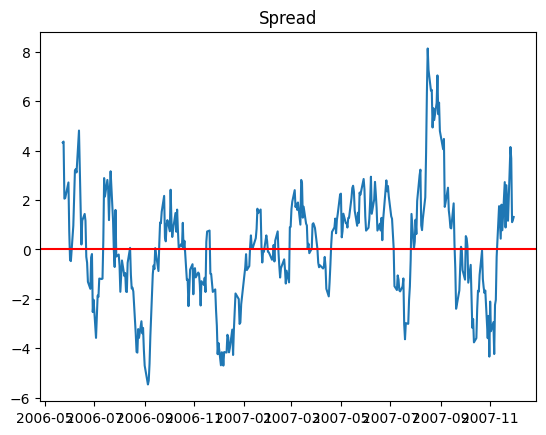

In [32]:
# spread (z) = GLD - hedge_ratio * GDX
z = df['Adj Close_GLD'] - hedge_ratio * df['Adj Close_GDX']
plt.plot(z)
plt.title('Spread')
plt.axhline(0, color='red')
plt.show()

In [33]:
prevz = z.shift()
dz = z - prevz
dz = dz[1:]
prevz = prevz[1:]

Calculate $\theta$ using ordinary least-squares regression.

In [34]:
model2 = OLS(dz, prevz - np.mean(prevz))
results2 = model2.fit()
theta = results2.params[0]
print(f'Theta: {theta}')

Theta: -0.08842255939100892


Calculate the halflife using the equation: $half life$ = $\frac{\ln(2)}{\theta}$

In [35]:
half_life = -np.log(2) / theta
print(f'Half-life: {half_life}')

Half-life: 7.83903095922404


In [37]:
# Exit method:
def determine_exit(hl, mu, position, spot):  # for mean reverting systems
    """
    An exit is triggered if the trade has been held for the half-life of the spread || the mean of the historical spread has been reached.
    :param hl: half-life of the spread
    :param mu: mean of the historical spread
    :param position: current position in the format {'entry_price': int, 'entry_date': datetime}
    :param spot: current spot price
    :return: boolean
    """
    return position['entry_date'] + pd.Timedelta(hl, unit='D') < pd.Timestamp.now() or (position['entry_price'] < mu and spot >= mu) or (position['entry_price'] > mu and spot <= mu)